# Linear Regression Assignment (Module 2)

#### Problem statement
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

The company wants to understand the factors affecting the demand for these shared bikes in the American market. 
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

#### Business goal
The goal is to model the demand for shared bikes with the available independent variables. 
It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations.

#### Data dictionary
day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Model libraries
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
# Read dataframe
day_df = pd.read_csv('day.csv')
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Identify target columns
After reading and understanding data dictionary, we can identify the target variable to be 'cnt'

# Data understanding

In [6]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [12]:
# Check for null values if any
day_df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [14]:
# Divide data between numerical and categorical columns
day_cat_col = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit']
day_num_col = ['temp', 'atemp', 'hum', 'windspeed']
day_cnt_col = ['casual', 'registered', 'cnt']
day_all_num_col = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']

# EDA

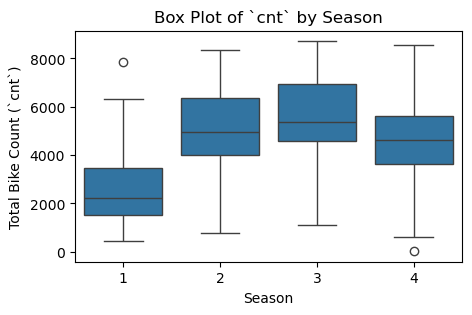

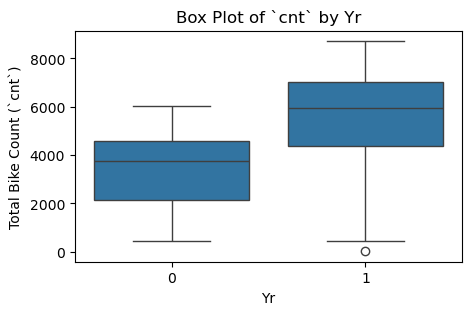

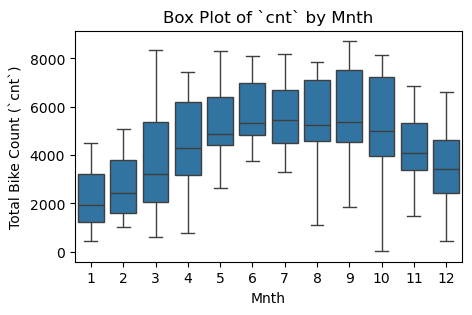

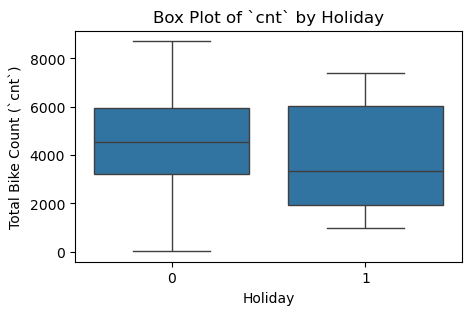

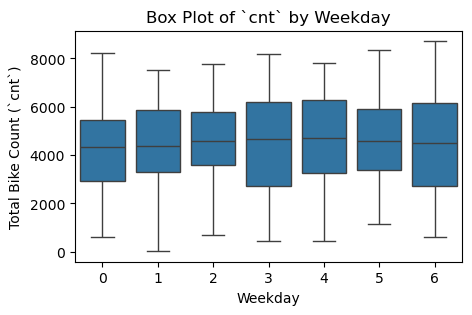

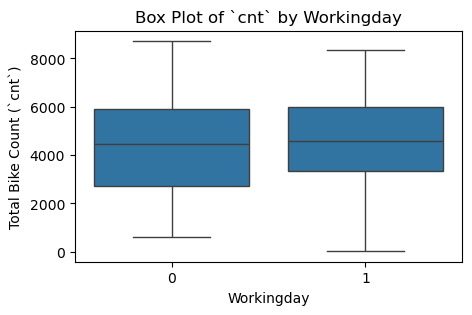

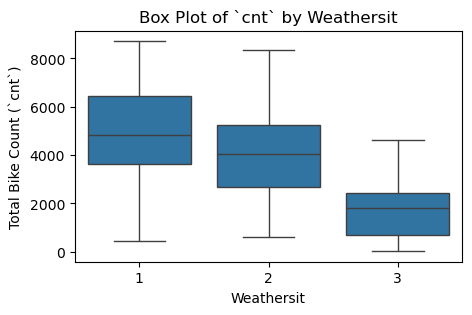

In [24]:
# Outlier check
# Boxplot for the category columns against count
for col in day_cat_col:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=col, y='cnt', data=day_df)
    plt.title(f'Box Plot of `cnt` by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Total Bike Count (`cnt`)')
    plt.show()

- The box plots clearly show a seasonal pattern in bike counts. The highest median bike count is observed in Fall, followed by Summer, Winter, and Spring. This indicates that more people tend to rent bikes during the Fall season.  
- The median bike count increased from 2018 to 2019, indicating a general upward trend in bike rentals.  
- The box plot clearly shows a seasonal pattern in bike counts. Bike rentals peak during the summer months (June to August) and are lowest during the winter months (January, February, December).   
- The median bike count is higher on non-holiday days than on holidays. This suggests that people tend to rent more bikes on non-holiday days.  
- The median bike count is relatively consistent across all weekdays, suggesting that bike usage doesn't vary significantly based on the day of the week.  
- The median bike count is similar on both working days and non-working days, suggesting that bike usage doesn't vary significantly based on whether it's a working day or not.  
- The median bike count is highest for weather situation 1, followed by weather situation 2, and lowest for weather situation 3.  

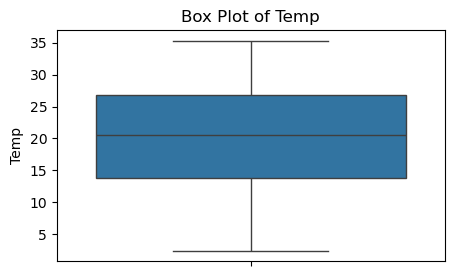

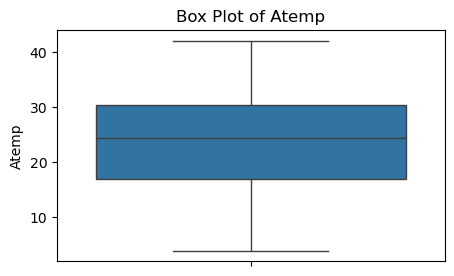

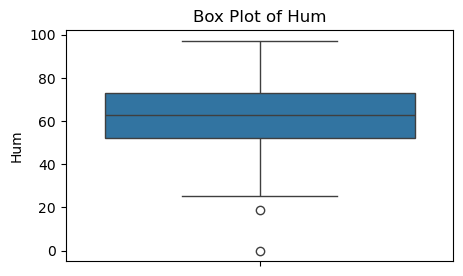

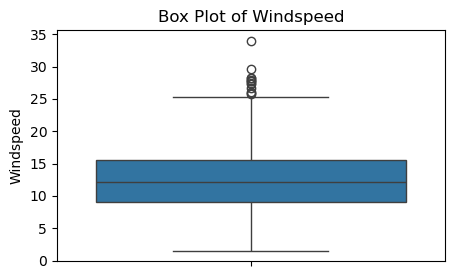

In [22]:
# Outlier check
# Boxplot for the Numeric columns against count
for col in day_num_col:
    plt.figure(figsize=(5, 3))
    sns.boxplot(y=day_df[col])
    plt.title(f'Box Plot of {col.capitalize()}')
    plt.ylabel(col.capitalize())
    plt.show()

#### Observations

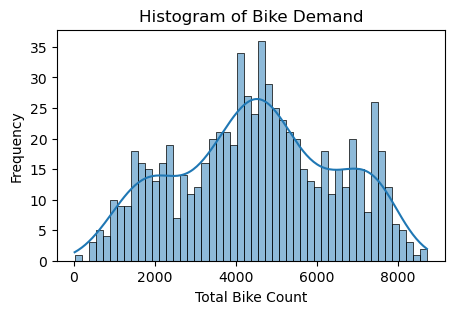

In [26]:
# Histogram for the 'cnt' column
plt.figure(figsize=(5, 3))
sns.histplot(day_df['cnt'], kde=True, bins=50)
plt.title('Histogram of Bike Demand')
plt.xlabel('Total Bike Count')
plt.ylabel('Frequency')
plt.show()

#### Observation  
The shape of the histogram roughly bell-shaped, which indicates a normal or near-normal distribution.
The peak of the distribution seems to be around the 4000-5000 range for total bike count.

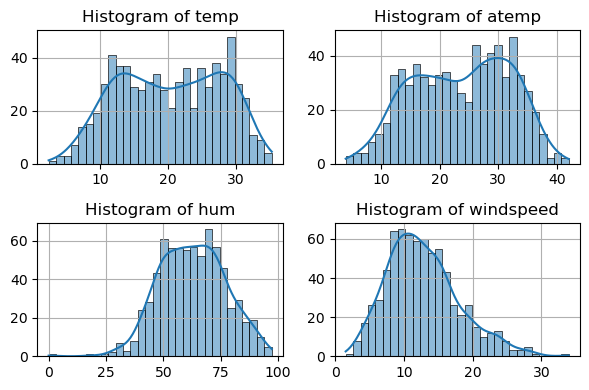

In [28]:
# Numerical variable analysis

# Histograms for each numerical columns
plt.figure(figsize=(6, 4))

for i, num in enumerate(day_num_col, 1):
    plt.subplot(2, 2, i)
    sns.histplot(day_df[num], kde=True, bins = 30)
    plt.title(f'Histogram of {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True)

plt.tight_layout()
plt.show()

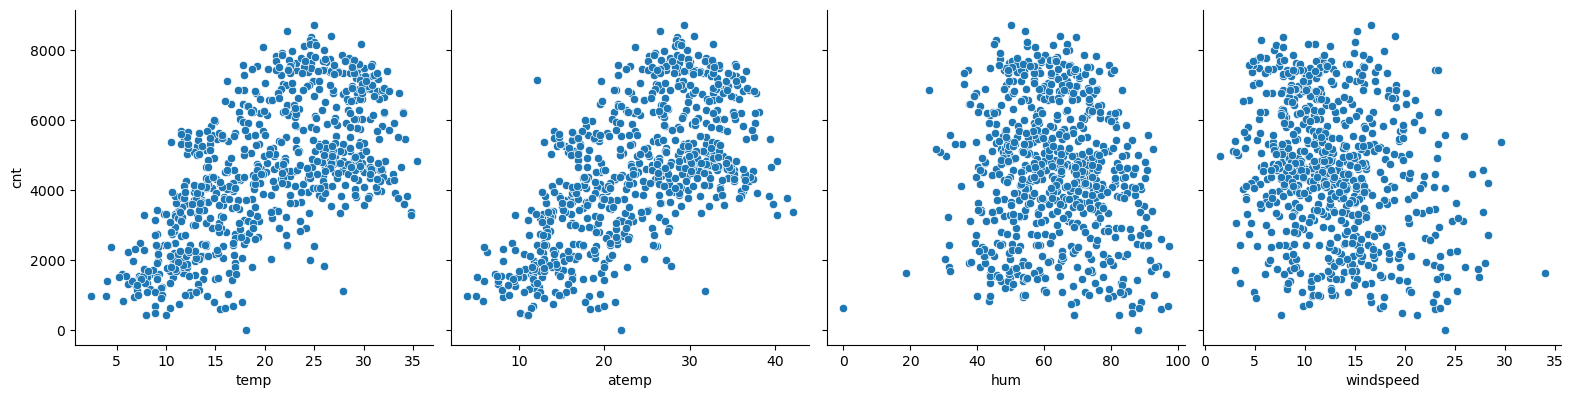

In [30]:
#Scatter plot to check correlation between parameters
sns.pairplot(day_df, x_vars=day_num_col, y_vars='cnt',size=4, aspect=1, kind='scatter')
plt.show()

#### Observation  
temp vs. cnt  
There seems to be a positive correlation between temperature and bike rentals.   
As the temperature increases, the number of bikes rented also tends to increase.  

atemp vs. cnt  
There's a positive correlation between perceived temperature and bike rentals.   
As the perceived temperature increases, the number of bikes rented also tends to increase. 

hum vs. cnt  
There doesn't seem to be a clear linear relationship between humidity and bike rentals. The points are scattered.  

windspeed vs. cnt  
There's a slight negative trend, suggesting that as wind speed increases, bike rentals might tend to decrease slightly.   
However, the relationship is not very strong.  

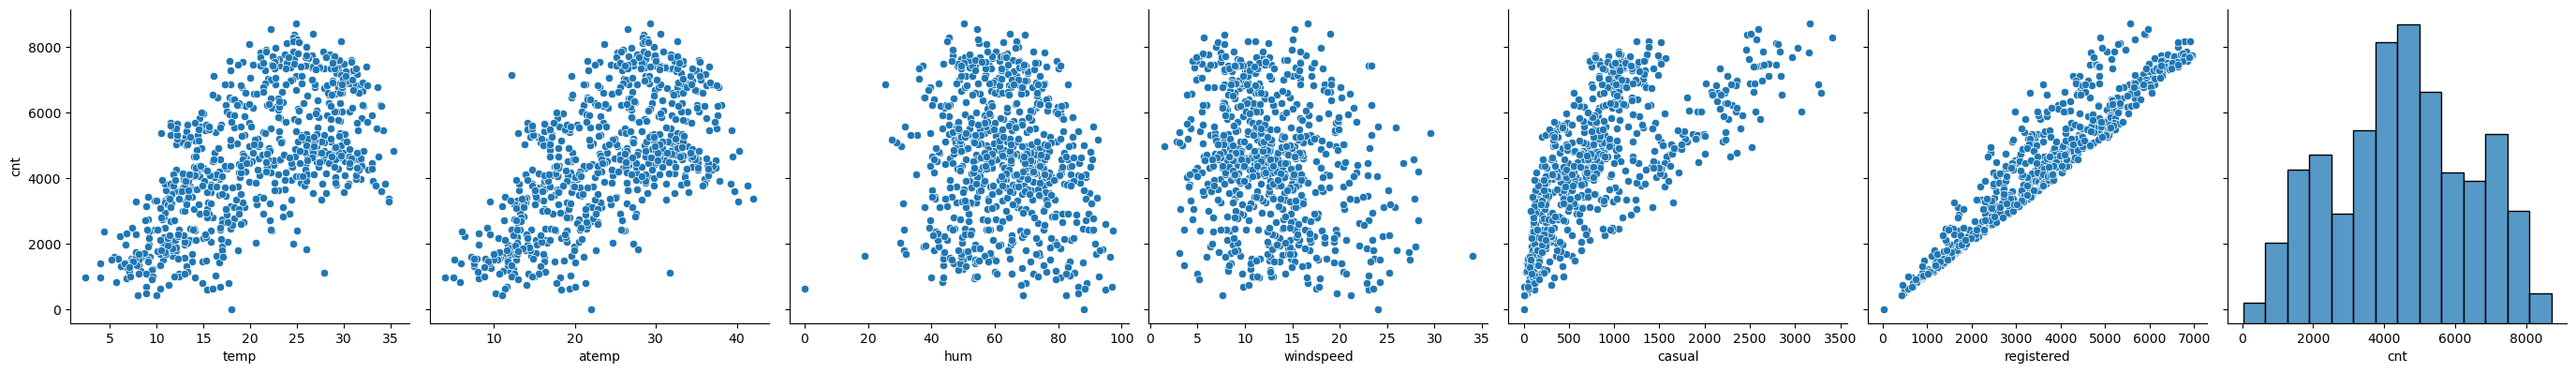

In [18]:
sns.pairplot(day_df, x_vars=day_all_num_col, y_vars='cnt',size=4, aspect=1, kind='scatter')
plt.show()

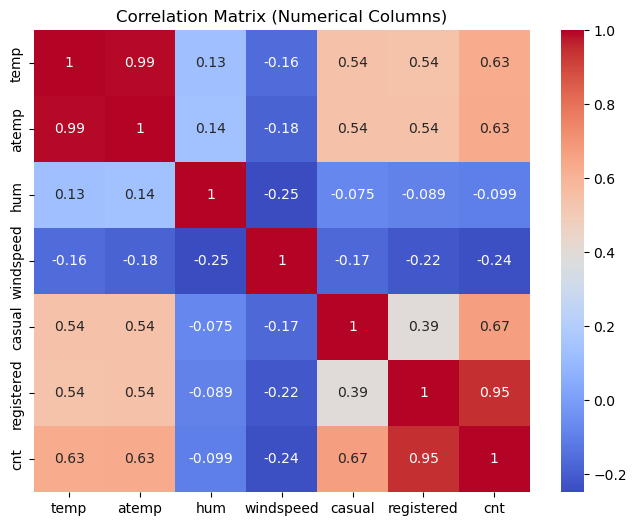

In [95]:
#Correlation plot for numrical columns
plt.figure(figsize=(8, 6))
sns.heatmap(day_df[day_all_num_col].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Columns)')
plt.show()

#### Observation  

Temperature and Perceived Temperature: These variables have a very strong positive correlation of 0.99, which makes sense as they are closely related.
These variable may cause multicolleanirity issue while building model and same needs to be taken care during feature selection.  
Similar observation for registered cnt and total bike counts(cnt).  
Temperature and Bike Count: There is a moderate positive correlation of 0.63 between temp and cnt. This indicates that higher temperatures tend to be associated with increased bike rentals.  
Humidity/Windspeed and Bike Count: There is a weak negative correlation of -0.099 between hum and cnt and also windspeed and count.

# Model building

#### Basic data preparation  
From heat map, we noticed that 'temp' and 'atemp' correlation is extremely high and it gives almost identical information (looking at data dictionary). to avoid multiple collinearity, it is better to consider only one variable (in this case 'temp' as it is pretty strainght forward).
#Also lets drop 'instant' and 'dteday' columns as each of the columns have unique entries and based on data undersyanding, it will not contribute to model building.

In [32]:
day_df_cln = day_df.drop(['atemp','dteday','instant'],axis=1)
day_df_cln.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,82,1518,1600


# Train-Test split  
Dividing the data ensures that we evaluate the model’s performance on data it hasn’t seen during training. This split helps to assess how well the model generalizes to new data.

In [34]:
np.random.seed(0)
df_train, df_test = train_test_split(day_df_cln, train_size = 0.7, test_size = 0.3, random_state = 100)
print("Training set:", df_train.shape)
print("Testing set:", df_test.shape)

Training set: (510, 13)
Testing set: (219, 13)


# Scaling  

Scaling is important in model building as it ensures that all features contribute equally by standardizing their ranges.
There are two common ways of rescaling:  
Min-Max scaling  
Standardisation  

We will use MinMaxScaler in this case

In [36]:
scaler = MinMaxScaler()
num_col = ['temp','hum', 'windspeed','casual', 'registered', 'cnt']
df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_test[num_col] = scaler.transform(df_test[num_col])
df_train.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
653,4,1,10,0,2,1,1,0.509887,0.575354,0.300794,0.280402,0.951776,0.864243
576,3,1,7,0,2,1,1,0.815169,0.725633,0.264686,0.294422,0.899220,0.827658
426,1,1,3,0,6,0,2,0.442393,0.640189,0.255342,0.290765,0.446145,0.465255
728,1,1,12,0,0,0,1,0.245101,0.498067,0.663106,0.110332,0.203869,0.204096
482,2,1,4,0,6,0,2,0.395666,0.504508,0.188475,0.340750,0.444701,0.482973


#### Identify dependent and independent variables  
In this case the target column is 'cnt' and thus same will be our dependent variable

In [38]:
#Training data
y_train = df_train.pop('cnt')
X_train = df_train

In [40]:
#test data
y_test = df_test.pop('cnt')
X_test = df_test

In [42]:
X_train.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered
653,4,1,10,0,2,1,1,0.509887,0.575354,0.300794,0.280402,0.951776
576,3,1,7,0,2,1,1,0.815169,0.725633,0.264686,0.294422,0.899220


# Simple Linear Regression

Equation of linear regression<br>
$y = c + m_1x_1 + m_2x_2 + ... + m_nx_n$

-  $y$ is the response
-  $c$ is the intercept
-  $m_*$ is the coefficient or model parameter
  
In simple linear regression only one independent variable is selected for model building

Looking at heatmap, we can say that 'temp' and 'cnt' have moderate positive correlation as compared to ohter numeric variables.
So in this case single independent variable selected is 'temp' and depenedent/target varible is 'cnt'

In [44]:
#Define variables for simple linear regression
X_train_slr = X_train['temp']
y_train_slr = y_train

In [46]:
# Add constant
# By default there is no constant considered when using statsmodel and the line passes through the origin.
# so intercept is added manually in this step
X_train_slr_sm = sm.add_constant(X_train_slr)

In [48]:
#Next step is to fit model using Ordinary Least Square (OLS) method
slr = sm.OLS(y_train_slr, X_train_slr_sm).fit()
slr.params

const    0.169798
temp     0.639952
dtype: float64

From above parameters, equation for the model considering simple linear regression is  
$ y = 0.17 + 0.64 * X $

In [50]:
# Perform a summary operation to evaluate view how well the model is fitted
print(slr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     359.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           5.80e-61
Time:                        22:13:00   Log-Likelihood:                 174.84
No. Observations:                 510   AIC:                            -345.7
Df Residuals:                     508   BIC:                            -337.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1698      0.020      8.628      0.0

#### Key observations
R-squared (0.414): This indicates that about 41.4% of the variance in the dependent variable (cnt - bike rentals count) is explained by the independent variable (temp - temperature). While this is a moderate value, it suggests that temperature alone does not capture all the factors affecting bike rentals.  

P>|t| for temp (0.000): The p-value for the temperature coefficient is less than 0.05, indicating that temperature is a statistically significant predictor of bike rentals.  

F-statistic (359.1) and Prob (F-statistic) (5.80e-61): The F-statistic is high with a very low p-value (close to 0), indicating that the model as a whole is statistically significant. This means that temp is a significant predictor of cnt.  

Model Fit: The model explains 41.4% of the variation in bike rentals based on temperature, which is moderate. 
Temperature significantly impacts bike rentals, but other variables may also play a role in predicting cnt more accurately.

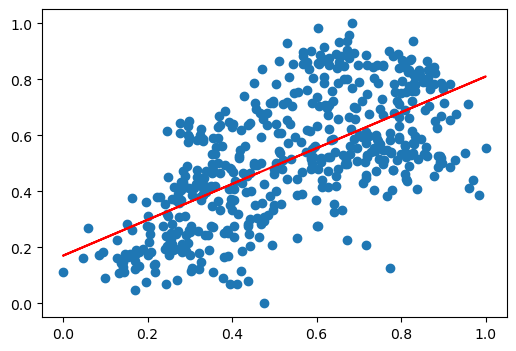

In [52]:
#Fit line visual representation
plt.figure(figsize=(6, 4))
plt.scatter(X_train_slr, y_train)
plt.plot(X_train_slr, 0.17 + 0.64*X_train_slr, 'r')
plt.show()

# Multiple Linear Regression  
It is an extension of simple linear regression where we model the relationship between a dependent variable and multiple independent variables.

Initially, lets consider all predictors for modelling as a step 1.
It provides a baseline performance metric (e.g., R-squared) and insights into how each feature initially impacts demand.
Also may help to detect issues like multicollinearity or overfitting.

#### Model 1

In [54]:
#Define variables for multiple linear regression
X_train_mlr1 = X_train
y_train_mlr1 = y_train

In [56]:
# Add constant
X_train_mlr1_sm = sm.add_constant(X_train_mlr1)

In [58]:
#fit model using Ordinary Least Square (OLS) method
mlr1 = sm.OLS(y_train_mlr1, X_train_mlr1_sm).fit()
mlr1.params

const         5.828671e-16
season       -8.500145e-17
yr           -1.543904e-16
mnth          5.063224e-17
holiday      -1.734723e-17
weekday      -9.020562e-17
workingday    1.144917e-16
weathersit   -1.249001e-16
temp          3.191891e-16
hum          -2.498002e-16
windspeed    -4.163336e-17
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [51]:
# Perform a summary operation to evaluate view how well the model is fitted
print(mlr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.630e+31
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:45:37   Log-Likelihood:                 17415.
No. Observations:                 510   AIC:                        -3.480e+04
Df Residuals:                     497   BIC:                        -3.475e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.829e-16   1.15e-16      5.088      0.0

#### Observation

Perfect R-squared and Adj. R-squared (1.000):

A perfect R-squared (1.000) is highly unusual and indicates that the model explains 100% of the variance in the dependent variable (cnt). This level of accuracy is almost always due to issues like multicollinearity, model overfitting, or data leakage.


# Feature Selection

To improve above model, we should address the multicollinearity and remove irrelevant predictors using feature selection method.
In this case we are using RFE + Manual feature selection approach

### Recursive Feature Elimination (RFE)   
RFE is a feature selection technique that recursively removes the least important features, based on the weights assigned by a specified machine learning model, to improve model performance.

In [60]:
# Initialize a Linear Regression model
model = LinearRegression()
# Define number of features to be selected. We have toatl 13 features included. We can start with 10 features.
n_features_to_select=10
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)

# Fit RFE on the scaled training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['season', 'yr', 'weekday', 'workingday', 'weathersit', 'temp', 'hum',
       'windspeed', 'casual', 'registered'],
      dtype='object')


#### Model 2

In [62]:
# Building model with features selected in RFE
#Define variables for multiple linear regression - selecting only features selected by RFE technique
X_train_mlr2 = X_train[selected_features]
y_train_mlr2 = y_train

# Add constant
X_train_mlr2_sm = sm.add_constant(X_train_mlr2)

#fit model using Ordinary Least Square (OLS) method
mlr2 = sm.OLS(y_train_mlr2, X_train_mlr2_sm).fit()
mlr2.params

const         3.469447e-16
season       -2.723516e-16
yr           -3.295975e-17
weekday      -2.029626e-16
workingday   -9.367507e-17
weathersit   -1.630640e-16
temp          1.665335e-16
hum          -3.330669e-16
windspeed    -3.330669e-16
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [175]:
print(mlr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.335e+30
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:54:47   Log-Likelihood:                 16730.
No. Observations:                 510   AIC:                        -3.344e+04
Df Residuals:                     499   BIC:                        -3.339e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.469e-16   4.32e-16      0.803      0.4

#### Observation  
Perfect R-squared and Adj. R-squared (1.000):

A perfect R-squared (1.000) is highly unusual and indicates that the model explains 100% of the variance in the dependent variable (cnt). This level of accuracy is almost always due to issues like multicollinearity, model overfitting, or data leakage.

# VIF  
Variance Inflation Factor (VIF) measures the extent of multicollinearity in a regression model, which occurs when independent variables are highly correlated.  
A high VIF (typically above 5 or 10) indicates that a predictor is strongly correlated with other predictors, which can make the model coefficients unstable and reduce the interpretability of the model. 
We will now calculate VIF and then drop feature one by one by looking ant VIF and P-value.

In [64]:
#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train[selected_features].columns
vif['VIF'] = [variance_inflation_factor(X_train[selected_features].values, i) for i in range(X_train[selected_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,registered,39.67
6,hum,24.11
5,temp,16.26
4,weathersit,14.20
0,season,9.74
3,workingday,9.52
8,casual,8.68
1,yr,5.66
7,windspeed,3.74
2,weekday,3.21


Looking at above table, we can see the column 'registered' has hightest VIF. Though it has low p-value, the VIF value is quite high. So lets drop this table and continue with model building.

In [66]:
# Building model with features selected in RFE
#Define variables for multiple linear regression
X_train_mlr3 = X_train_mlr2.drop('registered',axis=1)
y_train_mlr3 = y_train

# Add constant
X_train_mlr3_sm = sm.add_constant(X_train_mlr3)

#fit model using Ordinary Least Square (OLS) method
mlr3 = sm.OLS(y_train_mlr3, X_train_mlr3_sm).fit()
print(mlr3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     489.8
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.57e-241
Time:                        22:13:23   Log-Likelihood:                 620.93
No. Observations:                 510   AIC:                            -1222.
Df Residuals:                     500   BIC:                            -1180.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0683      0.022      3.062      0.0

In [68]:
#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train_mlr3.columns
vif['VIF'] = [variance_inflation_factor(X_train_mlr3.values, i) for i in range(X_train_mlr3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,hum,24.07
5,temp,14.29
4,weathersit,12.76
8,casual,7.36
0,season,7.03
3,workingday,5.32
7,windspeed,3.69
2,weekday,3.15
1,yr,2.36


In [70]:
# Building model with features selected in RFE
#Define variables for multiple linear regression
X_train_mlr4 = X_train_mlr3.drop('hum',axis=1)
y_train_mlr4 = y_train

# Add constant
X_train_mlr4_sm = sm.add_constant(X_train_mlr4)

#fit model using Ordinary Least Square (OLS) method
mlr4 = sm.OLS(y_train_mlr4, X_train_mlr4_sm).fit()
print(mlr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     550.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.24e-242
Time:                        22:13:30   Log-Likelihood:                 620.27
No. Observations:                 510   AIC:                            -1223.
Df Residuals:                     501   BIC:                            -1184.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0528      0.018      2.989      0.0

In [72]:
#Calculate VIF again to check if any variable is above acceptable range.
vif = pd.DataFrame()
vif['Features'] = X_train_mlr4.columns
vif['VIF'] = [variance_inflation_factor(X_train_mlr4.values, i) for i in range(X_train_mlr4.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,temp,13.69
7,casual,7.25
0,season,6.37
4,weathersit,6.07
3,workingday,5.14
6,windspeed,3.67
2,weekday,3.14
1,yr,2.36


In [76]:
# P value for all parameters is ok, howvere the VIF for 'temp' is pretty high. Lets drop 'temp' to build model further.
# Building model with features selected in RFE
#Define variables for multiple linear regression
X_train_mlr5 = X_train_mlr4.drop('temp',axis=1)
y_train_mlr5 = y_train

# Add constant
X_train_mlr5_sm = sm.add_constant(X_train_mlr5)

#fit model using Ordinary Least Square (OLS) method
mlr5 = sm.OLS(y_train_mlr5, X_train_mlr5_sm).fit()
print(mlr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     543.0
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.43e-229
Time:                        22:13:41   Log-Likelihood:                 586.36
No. Observations:                 510   AIC:                            -1157.
Df Residuals:                     502   BIC:                            -1123.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0659      0.019      3.508      0.0

In [78]:
#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train_mlr5.columns
vif['VIF'] = [variance_inflation_factor(X_train_mlr5.values, i) for i in range(X_train_mlr5.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,weathersit,5.95
0,season,5.93
5,windspeed,3.64
6,casual,3.47
3,workingday,3.45
2,weekday,3.13
1,yr,2.30


In [80]:
# The VIFs are now somewhat in acceptable range. However looking at p-value table, the p-value for 'weekday' column is more than 0.05.
# Lets drop this column and evaluate
# Building model with features selected in RFE
#Define variables for multiple linear regression
X_train_mlr6 = X_train_mlr5.drop('weekday',axis=1)
y_train_mlr6 = y_train

# Add constant
X_train_mlr6_sm = sm.add_constant(X_train_mlr6)

#fit model using Ordinary Least Square (OLS) method
mlr6 = sm.OLS(y_train_mlr6, X_train_mlr6_sm).fit()
print(mlr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     630.3
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.55e-230
Time:                        22:13:45   Log-Likelihood:                 584.79
No. Observations:                 510   AIC:                            -1156.
Df Residuals:                     503   BIC:                            -1126.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0727      0.018      3.942      0.0

In [82]:
#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train_mlr6.columns
vif['VIF'] = [variance_inflation_factor(X_train_mlr6.values, i) for i in range(X_train_mlr6.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,season,5.93
3,weathersit,5.65
4,windspeed,3.53
2,workingday,3.33
5,casual,3.26
1,yr,2.29


In [86]:
# As a step further, lets try dropping one more variable to check if VIF below 5 is acheived for all variables.
# Since there isn't much difference in values of 'season' and 'weathersit', we tried building model by remving both one by one 
#and noticed that when we remove 'season' the R-squared value reduced as compared to when we drop 'weathersit'.
# Thus we are dropping 'weathersit'
# Building model with features selected in RFE
#Define variables for multiple linear regression
X_train_mlr7 = X_train_mlr6.drop('weathersit',axis=1)
y_train_mlr7 = y_train

# Add constant
X_train_mlr7_sm = sm.add_constant(X_train_mlr7)

#fit model using Ordinary Least Square (OLS) method
mlr7 = sm.OLS(y_train_mlr7, X_train_mlr7_sm).fit()
print(mlr7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     643.2
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          4.19e-216
Time:                        22:13:54   Log-Likelihood:                 548.23
No. Observations:                 510   AIC:                            -1084.
Df Residuals:                     504   BIC:                            -1059.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0175      0.016     -1.062      0.2

In [88]:
vif = pd.DataFrame()
vif['Features'] = X_train_mlr7.columns
vif['VIF'] = [variance_inflation_factor(X_train_mlr7.values, i) for i in range(X_train_mlr7.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,season,5.00
4,casual,3.25
2,workingday,3.11
3,windspeed,2.92
1,yr,2.28


In [90]:
mlr7.params

const        -0.017481
season        0.043348
yr            0.170890
workingday    0.219272
windspeed    -0.065219
casual        0.815867
dtype: float64

# Residual Analysis  
Residual analysis calculates the differences (residuals) between observed and predicted values in a regression model. 

In [92]:
#Cauculate residual value
y_train_cnt = mlr7.predict(X_train_mlr7_sm)
res = y_train - y_train_cnt

Text(0.5, 0, 'Errors')

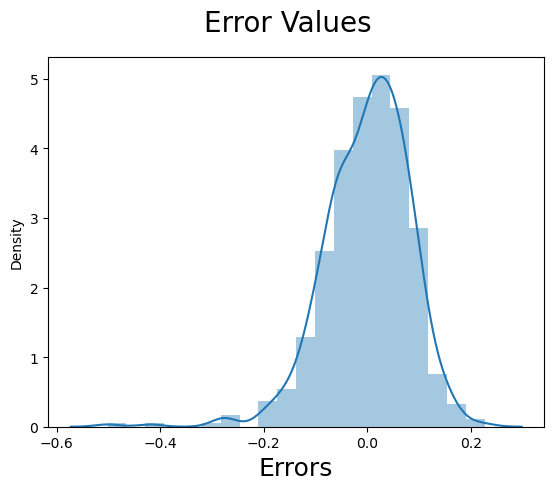

In [94]:
# Plot distribution of residuals. Ideally same shall follow normal distribution.
fig = plt.figure()
sns.distplot(res, bins = 20)
fig.suptitle('Error Values', fontsize = 20)             
plt.xlabel('Errors', fontsize = 18)

The plot for residual errors is normally distributed.

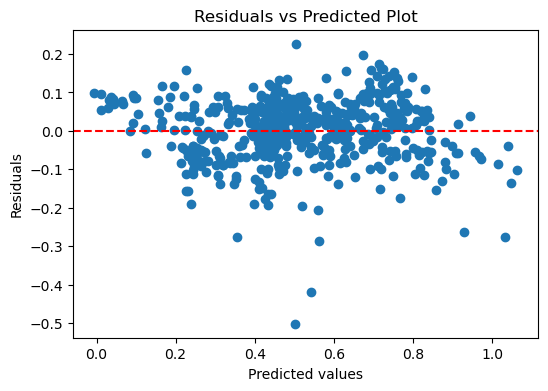

In [126]:
plt.figure(figsize=(6, 4))
predictions = mlr7.predict(X_train_mlr7_sm)
residuals = y_train - predictions
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Plot")
plt.show()

Plot the residuals (errors) against the predicted values is randomly scattered around zero without any clear pattern.

In [96]:
df_test.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered
184,3,0,7,1,1,0,2,0.831783,0.657364,0.084219,0.933557,0.427086
535,2,1,6,0,3,1,1,0.901354,0.610133,0.153728,0.265163,0.767976
299,4,0,10,0,4,1,2,0.511964,0.837699,0.334206,0.072539,0.346376
221,3,0,8,0,3,1,1,0.881625,0.437098,0.339570,0.268820,0.559630
152,2,0,6,0,4,1,1,0.817246,0.314298,0.537414,0.223712,0.608143


In [98]:
#Make sure that column in test data and model match.
X_test_new = X_test[X_train_mlr7.columns]
X_test_new.head()

,season,yr,workingday,windspeed,casual
184,3,0,0,0.084219,0.933557
535,2,1,1,0.153728,0.265163
299,4,0,1,0.334206,0.072539
221,3,0,1,0.339570,0.268820
152,2,0,1,0.537414,0.223712


In [100]:
# Add constant
X_test_new_sm = sm.add_constant(X_test_new)

In [102]:
#Calulate predicted y value based on the model
y_pred = mlr7.predict(X_test_new_sm)

In [104]:
y_pred.head()

184    0.868728
535    0.665689
299    0.412569
221    0.529011
152    0.435957
dtype: float64

In [106]:
#Calculate mean squared error
np.sqrt(mean_squared_error(y_test, y_pred))

0.08879560505634052

In [108]:
r_squared = r2_score(y_test, y_pred)
r_squared

0.8339925188266416

In [110]:
mlr7.params

const        -0.017481
season        0.043348
yr            0.170890
workingday    0.219272
windspeed    -0.065219
casual        0.815867
dtype: float64

Text(0, 0.5, 'y_pred')

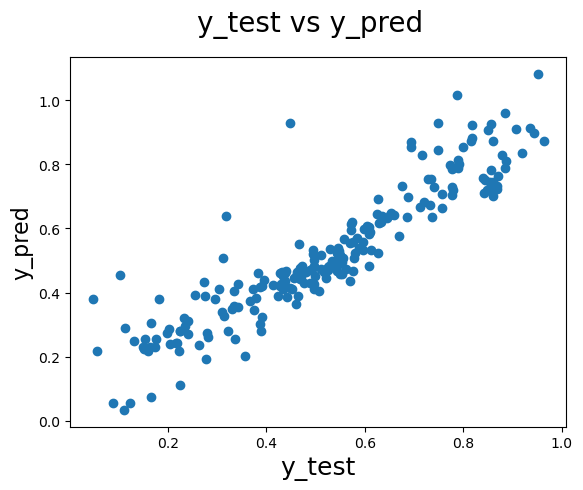

In [430]:
# Plotting y_test vs y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                         
plt.ylabel('y_pred', fontsize = 16)  

## R-Squared values for mlr 7 model:  
### On training data : 0.865  
### On testing data : 0.834  
From above parameters, equation for the model considering multiple linear regression is  
$ y = (-0.017) + 0.043 * X1 + 0.17 * X2 + 0.219 * X3 + (-0.065) * X4 + + 0.815 * X5 $

# Evaluation :  
Training R-squared: 0.865  
This indicates that 86.5% of the variance in the bike demand (cnt) is explained by the model on the training data.  
Testing R-squared: 0.833  
On the test data, 83.3% of the variance is explained, so we can safely assume that the model generalizes well.  

The VIF values are all below 5, suggesting low multicollinearity, which means that each predictor contributes unique information to the model, making it more stable and interpretable.

Interpretation of Key Features (Which variables are significant in predicting the demand for shared bikes):  
Season: Captures seasonal trends that influence bike rentals.   
Casual: Reflects the impact of temporary or recreational users on demand.  
Working Day: Helps differentiate commuting vs. recreational usage, showing demand patterns on working days.  
Windspeed: Reflects how wind speed influence biking convenience.  
Year (yr): Captures the growth in bike-sharing popularity from one year to the next, as more people adopt the service.  